# MLflow Integration with Machine Gnostics: Complete Tutorial

This notebook provides a comprehensive guide to using MLflow with Machine Gnostics models for experiment tracking, model versioning, and deployment.

## What You'll Learn

1. **Setup & Installation** - Configure MLflow with Machine Gnostics
2. **Basic Model Logging** - Track experiments and log models
3. **Model Loading & Inference** - Load saved models for predictions
4. **MLflow UI** - Visualize experiments and compare runs
5. **Model Registry** - Version and manage production models
6. **Multiple Experiments** - Compare different model configurations
7. **Best Practices** - Tips for effective experiment tracking

## Prerequisites

- Machine Gnostics library installed
- MLflow installed (`pip install mlflow`)
- Basic understanding of Machine Gnostics models

## Step 1: Installation & Setup

First, ensure you have all required packages installed.

In [1]:
# Install required packages (uncomment if needed)
# !pip install mlflow
# !pip install machinegnostics

import numpy as np
import mlflow
from mlflow.models import infer_signature
from machinegnostics.models import LogisticRegressor, LinearRegressor
from machinegnostics.integration import mlflow as mg_mlflow
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_regression

print("✓ All packages imported successfully")
print(f"MLflow version: {mlflow.__version__}")

✓ All packages imported successfully
MLflow version: 3.8.1


### Configure MLflow

Set the tracking URI and experiment name. MLflow will store all runs in this location.

In [2]:
# Set MLflow tracking URI (default is ./mlruns)
mlflow.set_tracking_uri("./mlruns")

# Create or set experiment
experiment_name = "Machine_Gnostics_Tutorial"
mlflow.set_experiment(experiment_name)

print(f"✓ MLflow experiment set: {experiment_name}")
print(f"✓ Tracking URI: {mlflow.get_tracking_uri()}")

✓ MLflow experiment set: Machine_Gnostics_Tutorial
✓ Tracking URI: ./mlruns


/Users/nirmal/Documents/np_research/ManGo_code/ManGo/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


## Step 2: Basic Model Logging

Learn how to train a model and log it with MLflow. This includes parameters, metrics, and the model artifact.

In [3]:
# Generate sample data for classification
np.random.seed(42)
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {X.shape[1]}")
print(f"Classes: {len(np.unique(y))}")

Training samples: 140
Test samples: 60
Features: 2
Classes: 2


### Train and Log Model

Use `mlflow.start_run()` context manager to track the experiment.

In [4]:
# Start MLflow run
with mlflow.start_run(run_name='LogReg_Degree3') as run:
    
    # 1. Initialize model with parameters
    model = LogisticRegressor(
        degree=3, 
        verbose=False, 
        early_stopping=True, 
        gnostic_characteristics=True
    )
    
    # 2. Train the model
    model.fit(X_train, y_train)
    
    # 3. Make predictions
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    
    # 4. Log parameters (model configuration)
    mlflow.log_param("model_type", "LogisticRegressor")
    mlflow.log_param("degree", model.degree)
    mlflow.log_param("early_stopping", True)
    mlflow.log_param("gnostic_characteristics", True)
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("test_size", len(X_test))
    
    # 5. Log metrics (performance measures)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("rentropy", model.re)
    
    # Log training history if available
    if hasattr(model, '_history') and model._history:
        if isinstance(model._history, dict):
            mlflow.log_metric("train_iterations", len(model._history['log_loss']))
            mlflow.log_metric("final_log_loss", model._history['log_loss'][-1])
        elif isinstance(model._history, list):
            mlflow.log_metric("train_iterations", len(model._history))
    
    # 6. Create model signature for input/output schema
    signature = infer_signature(X_train, y_pred)
    input_example = X_train[:3]
    
    # 7. Log the model artifact
    mg_mlflow.log_model(
        model, 
        artifact_path="model",
        signature=signature,
        input_example=input_example
    )
    
    # Save run_id for later use
    run_id = run.info.run_id
    
    print("=" * 60)
    print("MODEL TRAINING COMPLETED")
    print("=" * 60)
    print(f"Run ID: {run_id}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"R-Entropy: {model.re:.4f}")
    if hasattr(model, '_history') and isinstance(model._history, dict):
        print(f"Training Iterations: {len(model._history['log_loss'])}")
    print("=" * 60)

2026/01/23 18:11:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MODEL TRAINING COMPLETED
Run ID: a51a182ae52f49acaf5719d6ee3d6b3a
Accuracy: 0.9500
R-Entropy: 0.2873


## Step 3: Loading Saved Models

Learn how to load previously logged models for inference.

### Method 1: Load as PyFunc (Recommended)

This is the standard MLflow way to load models. It works with any MLflow-compatible model.

In [5]:
# Load model using MLflow's pyfunc interface
import pandas as pd

logged_model = f'runs:/{run_id}/model'
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Make predictions (MLflow expects DataFrame input)
test_df = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])
predictions = loaded_model.predict(test_df)

print("Model loaded successfully!")
print(f"Predictions shape: {predictions.shape}")
print(f"First 5 predictions: {predictions[:5]}")
print(f"Accuracy: {np.mean(predictions == y_test):.4f}")

2026/01/23 18:11:39 WARNING mlflow.pyfunc: The specified model does not have a specified Python version. It may be incompatible with the version of Python that is currently running: Python 3.11.12


Model loaded successfully!
Predictions shape: (60,)
First 5 predictions: [1 1 0 0 0]
Accuracy: 0.9500


### Method 2: Load Native Model

If you need access to Machine Gnostics-specific attributes (like weights, history), load the native model.

In [6]:
# Load the native Machine Gnostics model
from machinegnostics.integration.mlflow_flavor import load_model
import os

# Method 1: Download artifacts and load directly
artifact_path = mlflow.artifacts.download_artifacts(
    run_id=run_id,
    artifact_path="model"
)

# Load the native model
native_model = load_model(artifact_path)

# Now you can access all Machine Gnostics features
print("Native model loaded!")
print(f"Model type: {type(native_model).__name__}")
print(f"Degree: {native_model.degree}")
print(f"R-Entropy: {native_model.re:.4f}")
print(f"Weights shape: {native_model.weights.shape}")
print(f"Mean weight: {np.mean(native_model.weights):.4f}")

# Access training history (if available)
if hasattr(native_model, '_history') and native_model._history:
    print(f"\nTraining history available")
    if isinstance(native_model._history, dict):
        print(f"Iterations: {len(native_model._history.get('log_loss', []))}")

# Make predictions with native model
native_predictions = native_model.predict(X_test)
print(f"\nNative predictions match PyFunc: {np.array_equal(predictions, native_predictions)}")

Native model loaded!
Model type: LogisticRegressor
Degree: 3
R-Entropy: 0.2873
Weights shape: (140,)
Mean weight: 1.0000

Training history available

Native predictions match PyFunc: True


## Step 4: Viewing Results in MLflow UI

Launch the MLflow UI to visualize your experiments.

### Launch MLflow UI

Run the following command in your terminal:

```bash
mlflow ui
```

Then open your browser to: **http://localhost:5000**

**What you'll see:**
- **Experiments Tab**: All your experiments and runs
- **Parameters**: Model configuration (degree, early_stopping, etc.)
- **Metrics**: Performance measures (accuracy, R-entropy, etc.)
- **Artifacts**: Saved model files
- **Comparison View**: Compare multiple runs side-by-side

**Tip**: You can also programmatically query runs:

In [7]:
# Query runs programmatically
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiment = mlflow.get_experiment_by_name(experiment_name)

# Get all runs in the experiment
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

print("All Runs in Experiment:")
print("=" * 80)
print(runs[['run_id', 'params.degree', 'metrics.accuracy', 'metrics.rentropy']].head())
print("=" * 80)

All Runs in Experiment:
                             run_id params.degree  metrics.accuracy  \
0  a51a182ae52f49acaf5719d6ee3d6b3a             3          0.950000   
1  4cd91719eee14c5285367d8d15d8f6a0             1          0.833333   
2  0a1ade0c804943199ae48ec04114d041             3          0.950000   
3  65e0e4a7522a4eef82fa3d90833b118d             3          0.950000   
4  ce0d2e91230545f8b508a2ce09188529             3          0.950000   

   metrics.rentropy  
0          0.287266  
1               NaN  
2          0.287266  
3          0.287266  
4          0.287266  


## Step 5: Comparing Multiple Runs

Run experiments with different configurations to find the best model.

In [8]:
# Test different polynomial degrees
degrees = [1, 2, 3, 5]
results = []

for degree in degrees:
    with mlflow.start_run(run_name=f'LogReg_Degree{degree}'):
        # Train model
        model = LogisticRegressor(degree=degree, verbose=False, early_stopping=True)
        model.fit(X_train, y_train)
        
        # Evaluate
        y_pred = model.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        
        # Log everything
        mlflow.log_param("degree", degree)
        mlflow.log_param("model_type", "LogisticRegressor")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("rentropy", model.re)
        
        # Handle history (check if it's dict or list)
        iterations = 0
        if hasattr(model, '_history') and model._history:
            if isinstance(model._history, dict):
                iterations = len(model._history.get('log_loss', []))
            elif isinstance(model._history, list):
                iterations = len(model._history)
            mlflow.log_metric("iterations", iterations)
        
        # Create signature and log model
        signature = infer_signature(X_train, y_pred)
        mg_mlflow.log_model(model, artifact_path="model", signature=signature)
        
        results.append({
            'degree': degree,
            'accuracy': accuracy,
            'rentropy': model.re,
            'iterations': iterations
        })
        
        print(f"Degree {degree}: Accuracy={accuracy:.4f}, R-Entropy={model.re:.4f}")

print("\n" + "=" * 60)
print("EXPERIMENT COMPLETE - Check MLflow UI for comparisons")
print("=" * 60)

2026/01/23 18:11:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/23 18:11:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/23 18:11:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Degree 1: Accuracy=0.8333, R-Entropy=0.3280
Degree 2: Accuracy=0.9000, R-Entropy=0.4224
Degree 3: Accuracy=0.9500, R-Entropy=0.4793


2026/01/23 18:11:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Degree 5: Accuracy=0.9167, R-Entropy=0.4135

EXPERIMENT COMPLETE - Check MLflow UI for comparisons


### Visualize Comparison

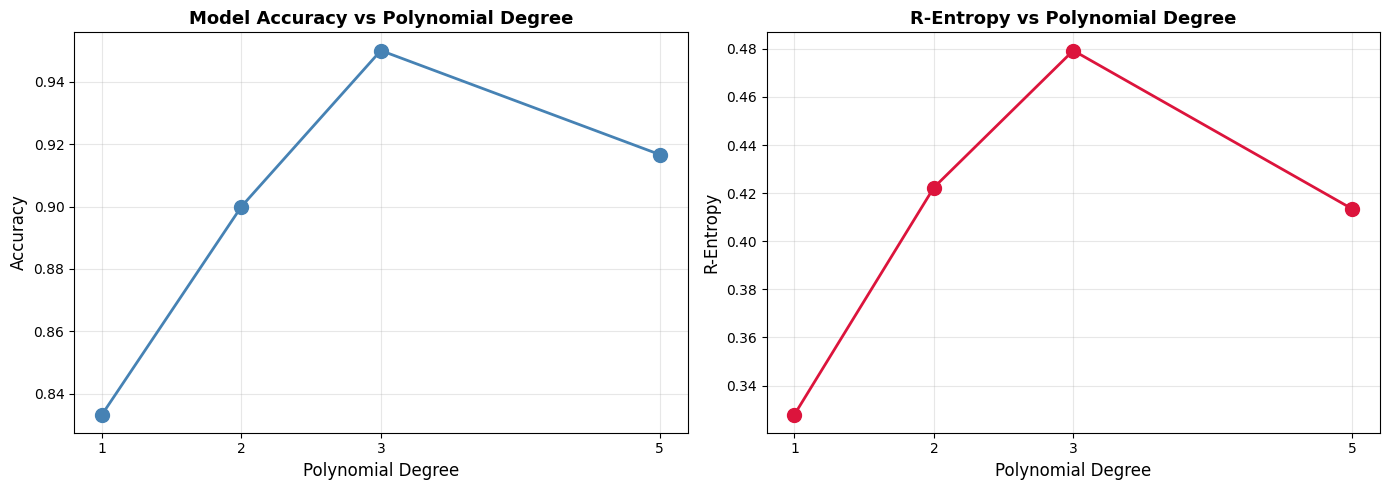


🏆 Best Model: Degree 3 with Accuracy 0.9500


In [9]:
import matplotlib.pyplot as plt

# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

degrees_list = [r['degree'] for r in results]
accuracies = [r['accuracy'] for r in results]
rentropies = [r['rentropy'] for r in results]

# Plot 1: Accuracy vs Degree
ax1.plot(degrees_list, accuracies, 'o-', linewidth=2, markersize=10, color='steelblue')
ax1.set_xlabel('Polynomial Degree', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy vs Polynomial Degree', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(degrees_list)

# Plot 2: R-Entropy vs Degree
ax2.plot(degrees_list, rentropies, 'o-', linewidth=2, markersize=10, color='crimson')
ax2.set_xlabel('Polynomial Degree', fontsize=12)
ax2.set_ylabel('R-Entropy', fontsize=12)
ax2.set_title('R-Entropy vs Polynomial Degree', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(degrees_list)

plt.tight_layout()
plt.show()

# Find best model
best_idx = np.argmax(accuracies)
print(f"\n🏆 Best Model: Degree {degrees_list[best_idx]} with Accuracy {accuracies[best_idx]:.4f}")

## Step 6: Model Registry (Production Deployment)

Register your best model for production use.

In [10]:
# Register the best model
model_name = "MG_LogisticRegressor_Production"

# Option 1: Register during logging (we did this earlier with registered_model_name)
# Option 2: Register an existing run's model
best_run = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.accuracy DESC"],
    max_results=1
).iloc[0]

best_run_id = best_run['run_id']
best_accuracy = best_run['metrics.accuracy']

print(f"Best Run ID: {best_run_id}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Register the model
model_uri = f"runs:/{best_run_id}/model"
registered_model = mlflow.register_model(model_uri, model_name)

print(f"\n✓ Model registered as: {model_name}")
print(f"  Version: {registered_model.version}")
print(f"  Status: {registered_model.status}")

/Users/nirmal/Documents/np_research/ManGo_code/ManGo/.venv/lib/python3.11/site-packages/mlflow/tracking/_model_registry/utils.py:216: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri)
Successfully registered model 'MG_LogisticRegressor_Production'.
2026/01/23 18:11:40 WARNING mlflow.tracking._model_registry.fluent: Run with id a02bab3e25de490bb05fc84f515c4971 has no artifacts at artifact path 'model', registering model based on models:/m-6ec3353f18544f5dbafccbf38c3dc6c9 instead


Best Run ID: a02bab3e25de490bb05fc84f515c4971
Best Accuracy: 0.9500

✓ Model registered as: MG_LogisticRegressor_Production
  Version: 1
  Status: READY


Created version '1' of model 'MG_LogisticRegressor_Production'.


### Load Production Model

Load the registered model by name and version.

In [11]:
# Load production model by name and version
production_model_uri = f"models:/{model_name}/latest"
production_model = mlflow.pyfunc.load_model(production_model_uri)

# Test the production model
test_df = pd.DataFrame(X_test[:10], columns=[f'feature_{i}' for i in range(X_test.shape[1])])
prod_predictions = production_model.predict(test_df)

print(f"Production Model: {model_name}")
print(f"Loaded version: latest")
print(f"\nSample predictions from production model:")
print(prod_predictions)
print(f"\nActual labels:")
print(y_test[:10])

2026/01/23 18:11:40 WARNING mlflow.pyfunc: The specified model does not have a specified Python version. It may be incompatible with the version of Python that is currently running: Python 3.11.12


Production Model: MG_LogisticRegressor_Production
Loaded version: latest

Sample predictions from production model:
[1 1 0 0 0 1 1 0 1 1]

Actual labels:
[1 1 0 0 0 1 1 0 1 1]


### Transition Model to Production

Move model through different stages: Staging → Production

In [12]:
# Transition model through stages
client = MlflowClient()

# Move to Staging
client.transition_model_version_stage(
    name=model_name,
    version=registered_model.version,
    stage="Staging"
)
print(f"✓ Model v{registered_model.version} moved to Staging")

# After testing, promote to Production
client.transition_model_version_stage(
    name=model_name,
    version=registered_model.version,
    stage="Production"
)
print(f"✓ Model v{registered_model.version} promoted to Production")

# View all versions
versions = client.search_model_versions(f"name='{model_name}'")
print(f"\nAll versions of {model_name}:")
for v in versions:
    print(f"  Version {v.version}: Stage={v.current_stage}, Run ID={v.run_id}")

✓ Model v1 moved to Staging
✓ Model v1 promoted to Production

All versions of MG_LogisticRegressor_Production:
  Version 1: Stage=Production, Run ID=a02bab3e25de490bb05fc84f515c4971


/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_98485/1376913986.py:5: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(
/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_98485/1376913986.py:13: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


## Step 7: Advanced Features

Additional MLflow capabilities for Machine Gnostics models.

### Logging Custom Artifacts

Save plots, data, and other files alongside your model.

In [13]:
with mlflow.start_run(run_name='With_Artifacts'):
    # Train model
    model = LogisticRegressor(degree=3, verbose=False)
    model.fit(X_train, y_train)
    
    # Log parameters and metrics
    mlflow.log_param("degree", 3)
    mlflow.log_metric("accuracy", np.mean(model.predict(X_test) == y_test))
    
    # Create and log a visualization
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='RdYlGn', 
               s=100, alpha=0.6, edgecolors='black')
    ax.set_title('Test Data Distribution')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    plt.savefig('data_distribution.png')
    mlflow.log_artifact('data_distribution.png')
    plt.close()
    
    # Log weights as numpy array
    np.save('model_weights.npy', model.weights)
    mlflow.log_artifact('model_weights.npy')
    
    # Log a text file with model summary
    with open('model_summary.txt', 'w') as f:
        f.write(f"Model Type: LogisticRegressor\n")
        f.write(f"Degree: {model.degree}\n")
        f.write(f"R-Entropy: {model.re:.4f}\n")
        f.write(f"Mean Weight: {np.mean(model.weights):.4f}\n")
        f.write(f"Std Weight: {np.std(model.weights):.4f}\n")
    mlflow.log_artifact('model_summary.txt')
    
    # Log the model
    signature = infer_signature(X_train, model.predict(X_train))
    mg_mlflow.log_model(model, artifact_path="model", signature=signature)
    
    print("✓ Artifacts logged successfully")
    print("  - data_distribution.png")
    print("  - model_weights.npy")
    print("  - model_summary.txt")

2026/01/23 18:11:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Artifacts logged successfully
  - data_distribution.png
  - model_weights.npy
  - model_summary.txt


### Logging Tags and Notes

Add metadata to organize and document your experiments.

In [14]:
with mlflow.start_run(run_name='Tagged_Run'):
    # Train model
    model = LogisticRegressor(degree=2, verbose=False)
    model.fit(X_train, y_train)
    
    # Log tags for organization
    mlflow.set_tag("model_family", "gnostic_classification")
    mlflow.set_tag("dataset", "two_moons")
    mlflow.set_tag("experiment_purpose", "tutorial")
    mlflow.set_tag("developer", "research_team")
    mlflow.set_tag("production_ready", "yes")
    
    # Add descriptive notes
    mlflow.set_tag("mlflow.note.content", 
                   "This model uses gnostic weights for robust classification. "
                   "Trained on synthetic two-moons dataset with 200 samples. "
                   "Achieves good separation with degree-2 polynomial features.")
    
    # Log model
    mlflow.log_param("degree", 2)
    mlflow.log_metric("accuracy", np.mean(model.predict(X_test) == y_test))
    signature = infer_signature(X_train, model.predict(X_train))
    mg_mlflow.log_model(model, artifact_path="model", signature=signature)
    
    print("✓ Tags and notes added:")
    print("  - model_family: gnostic_classification")
    print("  - dataset: two_moons")
    print("  - experiment_purpose: tutorial")
    print("  - production_ready: yes")
    print("\nTip: Use tags to filter runs in MLflow UI!")

2026/01/23 18:11:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Tags and notes added:
  - model_family: gnostic_classification
  - dataset: two_moons
  - experiment_purpose: tutorial
  - production_ready: yes

Tip: Use tags to filter runs in MLflow UI!


## Best Practices Summary

**Key Takeaways for Using MLflow with Machine Gnostics:**

### 1. **Experiment Organization**
- Use descriptive experiment names
- Tag runs with meaningful metadata
- Add notes to document findings

### 2. **Parameter Logging**
- Log all hyperparameters (degree, early_stopping, etc.)
- Include data split sizes
- Record preprocessing steps

### 3. **Metrics Tracking**
- Log standard metrics (accuracy, precision, recall)
- Log gnostic-specific metrics (R-entropy)
- Track training iterations and convergence

### 4. **Model Artifacts**
- Always include signature and input_example
- Save visualizations and plots
- Log model-specific data (weights, history)

### 5. **Model Registry**
- Register production-ready models
- Use staging stages for testing
- Version models systematically

### 6. **Reproducibility**
- Set random seeds
- Log environment information
- Document data sources

### 7. **MLflow UI Usage**
```bash
# Start UI
mlflow ui

# Start UI with specific host/port
mlflow ui --host 0.0.0.0 --port 8080
```

### 8. **Query Runs Programmatically**
```python
# Find best run by metric
best_runs = mlflow.search_runs(
    experiment_ids=[experiment_id],
    filter_string="metrics.accuracy > 0.9",
    order_by=["metrics.accuracy DESC"],
    max_results=5
)

# Load model from best run
best_model = mlflow.pyfunc.load_model(f"runs:/{best_runs.iloc[0].run_id}/model")
```

### 9. **Common Patterns**
- Use context managers (`with mlflow.start_run()`)
- Log incrementally during training
- Clean up temporary files after logging
- Test model loading before deployment

### 10. **Troubleshooting**
- Check `mlflow.get_tracking_uri()` if runs don't appear
- Verify artifact paths exist before logging
- Use native model loading for gnostic-specific features
- Ensure consistent MLflow versions across environments